# Loan default prediction using logistic regression

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load data

In [25]:
loan_data_frame = pd.read_csv('data.csv', usecols=['amount', 'employment', 'status']) # pandas.DataFrame

### Count of rows

In [3]:
len(loan_data_frame)

50000

### Example of training data

In [4]:
loan_data_frame.head(5)

,amount,employment,status
0,8000.0,Warehouseman,Charged Off
1,11000.0,Vice President,Fully Paid
2,35000.0,Owner/Attorney,Current
3,20000.0,Analyst,Fully Paid
4,12000.0,medical technician,Current


### Columns and their description
amount - loan amount  
employment - job title of applicant  
status - loan status

## Visualize data

Text(0.5, 1.0, 'Status distribution')

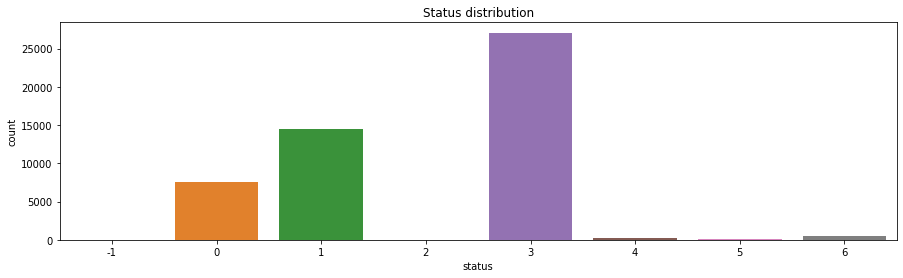

In [19]:
plt.figure(figsize=(15,4))
sns.countplot(x='status',data=loan_data_frame).set_title('Status distribution')

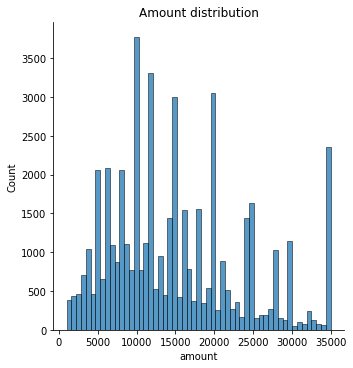

In [6]:
sns.displot(x='amount',data=loan_data_frame).set(title='Amount distribution')

### Empty values

In [7]:
loan_data_frame.isna().sum()

amount           1
employment    2785
status           1
dtype: int64

<AxesSubplot:>

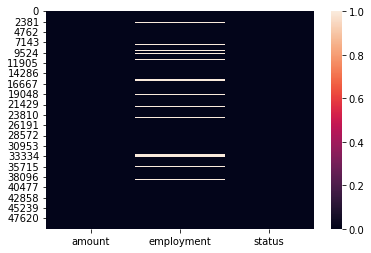

In [8]:
sns.heatmap(loan_data_frame.isna())

## Prepare data for the model

### Fill empty values

In [9]:
# Amount
mean_amount = loan_data_frame['amount'].mean()
loan_data_frame['amount'].fillna(mean_amount,inplace=True)
mean_amount

15145.52791055821

In [10]:
# Status
mean_status = loan_data_frame['status'].mode()
loan_data_frame['status'].fillna(mean_status[0],inplace=True)
mean_status[0]

'Fully Paid'

In [11]:
# Make sure there are no more NAs
loan_data_frame.isna().sum()

amount           0
employment    2785
status           0
dtype: int64

### Convert non-numerical values

In [12]:
loan_data_frame.dtypes

amount        float64
employment     object
status         object
dtype: object

In [30]:
# Convert strings to categorical integers
loan_data_frame['status'] = loan_data_frame['status'].astype('category').cat.codes
loan_data_frame['employment'] = loan_data_frame['employment'].astype('category').cat.codes

In [31]:
loan_data_frame.dtypes

amount        float64
employment      int16
status           int8
dtype: object